# Временные ряды
____
## Описание проекта

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

1. Загрузите данные и выполните их ресемплирование по одному часу.
2. Проанализируйте данные.
3. Обучите разные модели с различными гиперпараметрами. Сделайте тестовую выборку размером 10% от исходных данных.
4. Проверьте данные на тестовой выборке и сделайте выводы.
____
### Описание данных
* `num_orders` - количество заказов;
____
### Структура проекта
1. Подготовка данных
2. Анализ полученных данных
3. Обучение
    3.1. Подготовка данных к обучению
    3.2. LinearRegression
    3.3. DecisionTreeRegressor
    3.4. RandomForestRegressor
    3.5. CatBoostRegressor
    3.6. LGBMRegressor
4. Тестирование
5. Выводы
____
____

# 1. Подготовка

In [3]:
import pandas as pd
import numpy as np

# Модели
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import linear_model
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
# Метрики
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import make_scorer
# Инструменты
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV
import warnings
import os
from time import time
# Графика
import seaborn as sns
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')
%matplotlib inline
sns.set_style('darkgrid')
sns.set_context("paper")

C:\Anaconda3\envs\practicum\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
data = pd.read_csv('/datasets/taxi.csv', index_col=0, parse_dates=[0])
if not data.index.is_monotonic:
    data.sort_index(inplace=True)

data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [5]:
data.head(), data.tail()

(                     num_orders
 datetime                       
 2018-03-01 00:00:00           9
 2018-03-01 00:10:00          14
 2018-03-01 00:20:00          28
 2018-03-01 00:30:00          20
 2018-03-01 00:40:00          32,                      num_orders
 datetime                       
 2018-08-31 23:10:00          32
 2018-08-31 23:20:00          24
 2018-08-31 23:30:00          27
 2018-08-31 23:40:00          39
 2018-08-31 23:50:00          53)

Данные за полгода. 

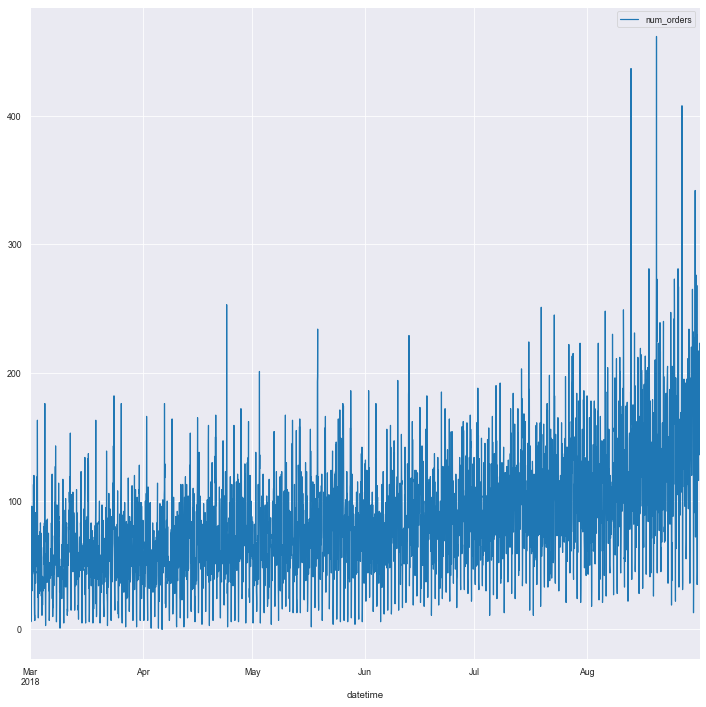

In [6]:
# Ресемлирования по одному часу
data = data.resample('1H').sum()
data.plot(figsize=(12, 12));

# 2. Анализ

In [7]:
# Посмотрим на данные в разрезе дня.
data_day = data.resample('1D').sum()
data_day.head()

,num_orders
datetime,
2018-03-01,1364
2018-03-02,1506
2018-03-03,1290
2018-03-04,1141
2018-03-05,1259


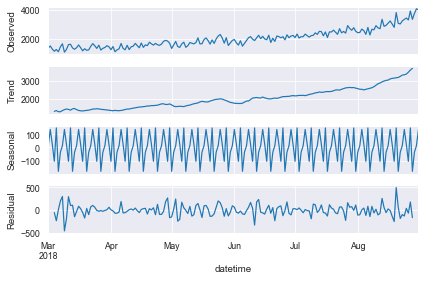

In [8]:
# Trend / Seasonality / Residuals:
decomposed = seasonal_decompose(data_day.num_orders)
decomposed.plot();

1. Растущий тренд;
2. Наличие сезонности;

Посмотрим на срез данных длиной в неделю.

In [9]:
data_week = data["2018-04-01" : "2018-04-08"]
data_week.head()

,num_orders
datetime,
2018-04-01 00:00:00,85
2018-04-01 01:00:00,42
2018-04-01 02:00:00,34
2018-04-01 03:00:00,24
2018-04-01 04:00:00,39


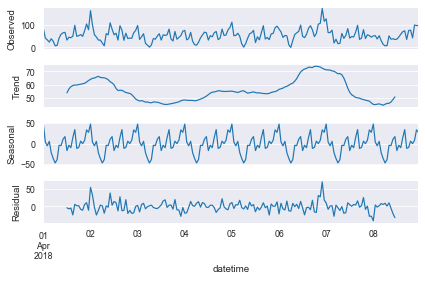

In [10]:
# Trend / Seasonality / Residuals:
decomposed = seasonal_decompose(data_week.num_orders)
decomposed.plot();

Наблюдаются та же сезонность, только еженедельная.
1. Пики от вечера пт до утра понедельника;
2. В течение дня больший спос по вечерам.

Проанализируем и сделаем вывод касательно использования признаков сезонности.  
* `ГОД`— диапазон данных меньше года => будет просто константа, не подходит;
* `МЕСЯЦ` — аналогично году, малый диапазон данных;
* `ДЕНЬ` — не имеет смысла, т.к. добавим лишь последовательность чисел;
* `ДЕНЬ НЕДЕЛИ` — есть недельная сезонность, добавляем;
* `ЧАС` — есть суточная сезонность, добавляем;

На основании этого выделяем следующие признаки:
1. День недели;
2. Час.

In [11]:
def make_features(data, max_lag : int, rolling_window : int):
    data["dayofweek"] = data.index.dayofweek
    data["hour"] = data.index.hour
    # Lag
    for lag in range(1, max_lag + 1):
        data[f"lag_{lag}"] = data.num_orders.shift(lag)
    # Rolling_window
    data["rolling_mean"] = data.num_orders.shift().rolling(rolling_window).mean()

In [12]:
# Изменил кол-во лагов до неделя + 1.
week = 7
make_features(data, max_lag=week + 1, rolling_window=3 * week)

In [13]:
data.sample(10)

,num_orders,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,rolling_mean
datetime,,,,,,,,,,,,
2018-03-29 18:00:00,44,3,18,31.0,120.0,74.0,40.0,51.0,33.0,81.0,72.0,60.047619
2018-07-31 18:00:00,42,1,18,112.0,100.0,99.0,75.0,58.0,85.0,119.0,134.0,107.380952
2018-07-12 02:00:00,107,3,2,145.0,129.0,96.0,93.0,94.0,92.0,76.0,80.0,95.809524
2018-07-28 13:00:00,63,5,13,75.0,104.0,108.0,113.0,73.0,39.0,44.0,91.0,124.238095
2018-08-08 07:00:00,27,2,7,60.0,86.0,104.0,104.0,157.0,154.0,230.0,103.0,105.476190
2018-05-01 05:00:00,25,1,5,77.0,84.0,55.0,74.0,81.0,77.0,85.0,88.0,73.190476
2018-03-15 04:00:00,15,3,4,42.0,55.0,85.0,123.0,65.0,81.0,77.0,83.0,60.761905
2018-05-15 17:00:00,53,1,17,130.0,66.0,68.0,82.0,41.0,71.0,50.0,80.0,71.523810
2018-03-08 04:00:00,60,3,4,68.0,65.0,78.0,143.0,94.0,127.0,108.0,76.0,65.809524


# 3. Обучение

In [14]:
train, test = train_test_split(
    data, 
    test_size = .1, 
    shuffle = False,
    random_state = 2718
)
train, test = train.dropna(), test.dropna()
train.shape, test.shape

((3953, 12), (442, 12))

In [15]:
y_train, y_test = train.num_orders, test.num_orders
X_train, X_test = train.drop("num_orders", axis=1), test.drop("num_orders", axis=1)
X_train.head()

,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,rolling_mean
datetime,,,,,,,,,,,
2018-03-01 21:00:00,3,21,61.0,45.0,73.0,44.0,43.0,66.0,48.0,32.0,53.666667
2018-03-01 22:00:00,3,22,66.0,61.0,45.0,73.0,44.0,43.0,66.0,48.0,50.904762
2018-03-01 23:00:00,3,23,113.0,66.0,61.0,45.0,73.0,44.0,43.0,66.0,52.238095
2018-03-02 00:00:00,4,0,58.0,113.0,66.0,61.0,45.0,73.0,44.0,43.0,51.619048
2018-03-02 01:00:00,4,1,90.0,58.0,113.0,66.0,61.0,45.0,73.0,44.0,52.761905


In [16]:
def rmse(y_true, y_pred): return np.sqrt(mse(y_true, y_pred))

In [17]:
# scorer = make_scorer(rmse, greater_is_better=False)

In [18]:
# Диапазон значений
# Хотим, чтобы тест занимал не больше месяца. 
# Поэтому вычислим разницу между крайними значениями и поделим на число дней в месяце. Результат =: n_splits.
n_splits = (X_test.iloc[-1].name - X_train.iloc[0].name).days // 30

In [19]:
def plot_predictions(X, y, y_pred, rolling):
    plt.figure(figsize=(16, 8))
    sns.lineplot(y.index, y.rolling(rolling).mean())
    sns.lineplot(y.index, pd.Series(data=y_pred, index=y.index).rolling(rolling).mean())
    plt.legend(['target', 'predictions'], fontsize=12)
    plt.title('Target & Predictions view on cross-validation', fontsize=14)
    plt.show()

In [20]:
def cross_validation(model, X, y, param_grid, rolling_plot):
    # TimeSeriesSplit
    tscv = TimeSeriesSplit(n_splits=n_splits)
    model_cv = GridSearchCV(
        model(),
        param_grid = param_grid,
        cv = tscv,
        scoring = 'neg_mean_squared_error',
        n_jobs=-1, 
        verbose=1,
        return_train_score=True
    )
    # Подбор гиперпараметров
    model_cv = model_cv.fit(X, y)
    # Best etimator
    model_best = model_cv.best_estimator_
    cv_results = model_cv.cv_results_
    # Train
    start_time = time()
    model_best.fit(X, y)
    train_time = time() - start_time
    # Predict
    start_time = time()
    predictions = model_best.predict(X)
    predict_time = time() - start_time
    # RMSE
    rmse_metrics = rmse(y, predictions)
    
    # Call plot_predictions
    plot_predictions(X, y, y_pred=predictions, rolling=rolling_plot)
    # Result list
    rlt = [{
        "Model name" : type(model_best).__name__,
        "Train time" : round(train_time, 4),
        "Predict time" : round(predict_time, 4),
        "RMSE train_score" : -model_cv.best_score_.round(4),
        "RMSE predict_score" : round(rmse_metrics, 4),
        "Parameters" : model_cv.best_params_
    }]
    return model_best, model_cv.best_params_, rlt

In [21]:
# List for model results
results = []
rolling_plot = 21

### LinearRegression

In [22]:
lr_params = {}

Fitting 6 folds for each of 1 candidates, totalling 6 fits


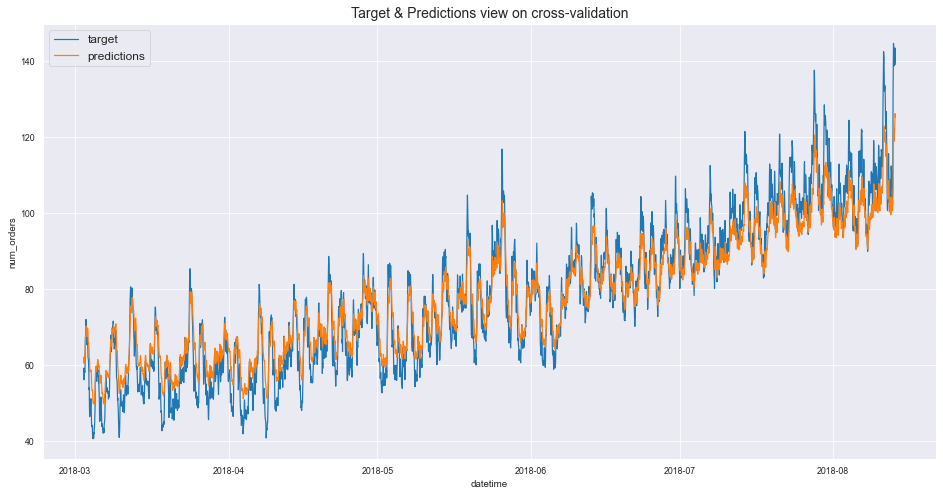

Wall time: 2.65 s


{'Model name': 'LinearRegression',
 'Train time': 0.003,
 'Predict time': 0.002,
 'RMSE train_score': 1078.9718,
 'RMSE predict_score': 31.1727,
 'Parameters': {}}

In [23]:
%%time

lr, lr_params, lr_result = cross_validation(
    model=LinearRegression,
    X = X_train,
    y = y_train,
    param_grid = {},
    rolling_plot = rolling_plot
);
results += lr_result
results[-1]

### DecisionTreeRegressor

In [24]:
tree_params = {
    "max_depth" : range(1, 5),
    "min_samples_split" : range(2, 5),
    "min_samples_leaf" : range(1, 4),
    "random_state" : [2718]
}

Fitting 6 folds for each of 36 candidates, totalling 216 fits


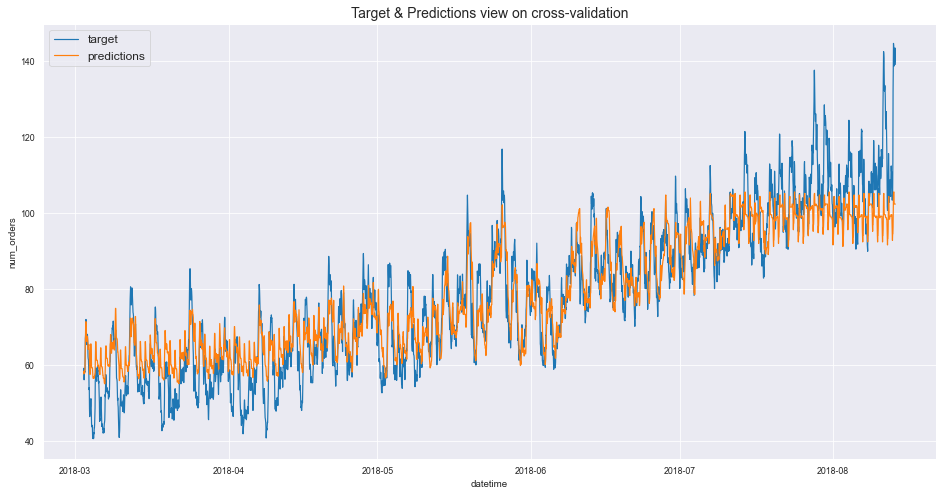

Wall time: 2.3 s


{'Model name': 'DecisionTreeRegressor',
 'Train time': 0.012,
 'Predict time': 0.003,
 'RMSE train_score': 1024.0131,
 'RMSE predict_score': 27.0127,
 'Parameters': {'max_depth': 4,
  'min_samples_leaf': 1,
  'min_samples_split': 2,
  'random_state': 2718}}

In [25]:
%%time

tree, tree_params, tree_result = cross_validation(
    model=DecisionTreeRegressor,
    X = X_train,
    y = y_train,
    param_grid = tree_params,
    rolling_plot = rolling_plot
)
results += tree_result
results[-1]

### RandomForestRegressor

In [26]:
rf_params = {
    "max_depth" : range(1, 5),
    "min_samples_split" : range(2, 5),
    "min_samples_leaf" : range(1, 4),
    "random_state" : [2718]
}

Fitting 6 folds for each of 36 candidates, totalling 216 fits


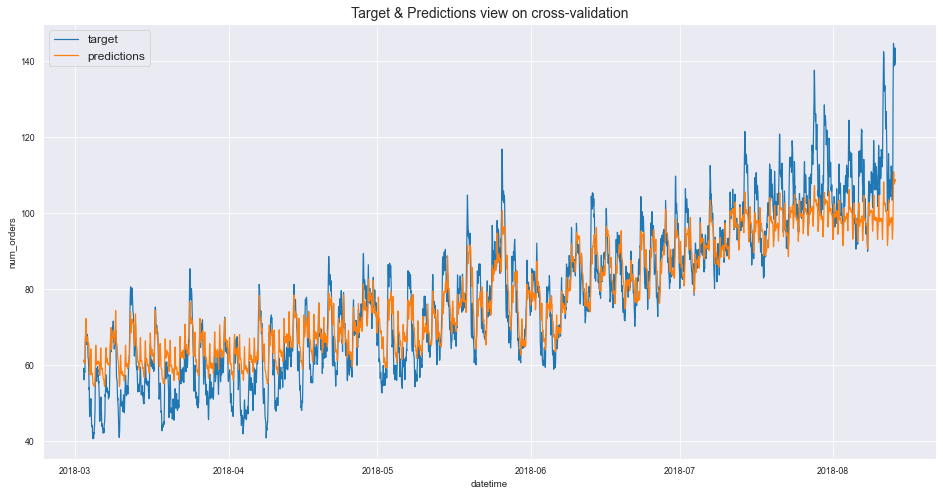

Wall time: 14.2 s


{'Model name': 'RandomForestRegressor',
 'Train time': 0.5266,
 'Predict time': 0.015,
 'RMSE train_score': 934.6907,
 'RMSE predict_score': 25.6112,
 'Parameters': {'max_depth': 4,
  'min_samples_leaf': 2,
  'min_samples_split': 2,
  'random_state': 2718}}

In [27]:
%%time

rf, rf_params, rf_result = cross_validation(
    model = RandomForestRegressor,
    X = X_train,
    y = y_train,
    param_grid = rf_params,
    rolling_plot = rolling_plot
)
results += rf_result
results[-1]

### CatBoostRegressor

In [28]:
cbr_params = {
    "iterations" : range(400, 1000 + 1, 200),
    "learning_rate" : [0.05, 0.1, 0.15],
    "random_state" : [2718]
}

Fitting 6 folds for each of 12 candidates, totalling 72 fits
0:	learn: 37.7069962	total: 136ms	remaining: 1m 21s
1:	learn: 36.8765928	total: 140ms	remaining: 41.8s
2:	learn: 36.0763284	total: 143ms	remaining: 28.4s
3:	learn: 35.3266737	total: 146ms	remaining: 21.7s
4:	learn: 34.6499026	total: 148ms	remaining: 17.6s
5:	learn: 33.9201953	total: 150ms	remaining: 14.8s
6:	learn: 33.3400371	total: 152ms	remaining: 12.9s
7:	learn: 32.7267987	total: 154ms	remaining: 11.4s
8:	learn: 32.1918901	total: 155ms	remaining: 10.2s
9:	learn: 31.7960271	total: 157ms	remaining: 9.28s
10:	learn: 31.3669290	total: 159ms	remaining: 8.52s
11:	learn: 30.9086656	total: 161ms	remaining: 7.89s
12:	learn: 30.4786601	total: 163ms	remaining: 7.35s
13:	learn: 30.1215450	total: 165ms	remaining: 6.89s
14:	learn: 29.7633359	total: 167ms	remaining: 6.49s
15:	learn: 29.4626429	total: 168ms	remaining: 6.14s
16:	learn: 29.1178258	total: 170ms	remaining: 5.84s
17:	learn: 28.8233153	total: 172ms	remaining: 5.56s
18:	learn: 2

167:	learn: 21.1534325	total: 471ms	remaining: 1.21s
168:	learn: 21.1301591	total: 475ms	remaining: 1.21s
169:	learn: 21.1192282	total: 478ms	remaining: 1.21s
170:	learn: 21.1127395	total: 481ms	remaining: 1.21s
171:	learn: 21.0719289	total: 484ms	remaining: 1.2s
172:	learn: 21.0667554	total: 486ms	remaining: 1.2s
173:	learn: 21.0566009	total: 488ms	remaining: 1.2s
174:	learn: 21.0464447	total: 490ms	remaining: 1.19s
175:	learn: 21.0124252	total: 492ms	remaining: 1.19s
176:	learn: 21.0017735	total: 494ms	remaining: 1.18s
177:	learn: 20.9816527	total: 495ms	remaining: 1.17s
178:	learn: 20.9612837	total: 497ms	remaining: 1.17s
179:	learn: 20.9518071	total: 499ms	remaining: 1.16s
180:	learn: 20.9450196	total: 501ms	remaining: 1.16s
181:	learn: 20.9206765	total: 503ms	remaining: 1.15s
182:	learn: 20.8948476	total: 504ms	remaining: 1.15s
183:	learn: 20.8657602	total: 506ms	remaining: 1.14s
184:	learn: 20.8348739	total: 508ms	remaining: 1.14s
185:	learn: 20.8256724	total: 510ms	remaining: 1.

347:	learn: 18.2883707	total: 807ms	remaining: 584ms
348:	learn: 18.2703567	total: 809ms	remaining: 582ms
349:	learn: 18.2618863	total: 810ms	remaining: 579ms
350:	learn: 18.2488629	total: 812ms	remaining: 576ms
351:	learn: 18.2405235	total: 814ms	remaining: 573ms
352:	learn: 18.2252512	total: 816ms	remaining: 571ms
353:	learn: 18.2174872	total: 818ms	remaining: 568ms
354:	learn: 18.2111992	total: 819ms	remaining: 565ms
355:	learn: 18.2002912	total: 821ms	remaining: 563ms
356:	learn: 18.1858241	total: 823ms	remaining: 560ms
357:	learn: 18.1764775	total: 825ms	remaining: 557ms
358:	learn: 18.1648540	total: 826ms	remaining: 555ms
359:	learn: 18.1508410	total: 828ms	remaining: 552ms
360:	learn: 18.1424111	total: 830ms	remaining: 549ms
361:	learn: 18.1276951	total: 832ms	remaining: 547ms
362:	learn: 18.1036207	total: 834ms	remaining: 544ms
363:	learn: 18.0955046	total: 836ms	remaining: 542ms
364:	learn: 18.0873513	total: 837ms	remaining: 539ms
365:	learn: 18.0751013	total: 839ms	remaining:

503:	learn: 16.6459395	total: 1.12s	remaining: 214ms
504:	learn: 16.6453335	total: 1.13s	remaining: 212ms
505:	learn: 16.6336115	total: 1.13s	remaining: 210ms
506:	learn: 16.6332082	total: 1.13s	remaining: 207ms
507:	learn: 16.6246329	total: 1.13s	remaining: 205ms
508:	learn: 16.6120636	total: 1.13s	remaining: 203ms
509:	learn: 16.6096829	total: 1.14s	remaining: 201ms
510:	learn: 16.5949687	total: 1.14s	remaining: 198ms
511:	learn: 16.5902731	total: 1.14s	remaining: 196ms
512:	learn: 16.5860283	total: 1.14s	remaining: 194ms
513:	learn: 16.5712496	total: 1.15s	remaining: 192ms
514:	learn: 16.5593980	total: 1.15s	remaining: 190ms
515:	learn: 16.5488797	total: 1.15s	remaining: 187ms
516:	learn: 16.5484963	total: 1.15s	remaining: 185ms
517:	learn: 16.5361626	total: 1.15s	remaining: 183ms
518:	learn: 16.5324405	total: 1.16s	remaining: 181ms
519:	learn: 16.5242401	total: 1.16s	remaining: 178ms
520:	learn: 16.5187111	total: 1.16s	remaining: 176ms
521:	learn: 16.5119735	total: 1.16s	remaining:

62:	learn: 23.7223984	total: 120ms	remaining: 1.02s
63:	learn: 23.6704631	total: 122ms	remaining: 1.02s
64:	learn: 23.6163057	total: 124ms	remaining: 1.02s
65:	learn: 23.5208736	total: 126ms	remaining: 1.02s
66:	learn: 23.4986091	total: 128ms	remaining: 1.01s
67:	learn: 23.4919478	total: 129ms	remaining: 1.01s
68:	learn: 23.4594825	total: 131ms	remaining: 1.01s
69:	learn: 23.4514950	total: 133ms	remaining: 1.01s
70:	learn: 23.4324326	total: 135ms	remaining: 1s
71:	learn: 23.4230280	total: 136ms	remaining: 1s
72:	learn: 23.4178314	total: 138ms	remaining: 993ms
73:	learn: 23.4108677	total: 139ms	remaining: 990ms
74:	learn: 23.4017086	total: 141ms	remaining: 987ms
75:	learn: 23.3818634	total: 143ms	remaining: 984ms
76:	learn: 23.3058935	total: 145ms	remaining: 982ms
77:	learn: 23.2939734	total: 146ms	remaining: 978ms
78:	learn: 23.2360038	total: 148ms	remaining: 976ms
79:	learn: 23.1951753	total: 150ms	remaining: 974ms
80:	learn: 23.1331162	total: 152ms	remaining: 972ms
81:	learn: 23.1211

249:	learn: 19.7973156	total: 456ms	remaining: 639ms
250:	learn: 19.7760734	total: 458ms	remaining: 637ms
251:	learn: 19.7657040	total: 460ms	remaining: 636ms
252:	learn: 19.7525437	total: 462ms	remaining: 634ms
253:	learn: 19.7292585	total: 464ms	remaining: 632ms
254:	learn: 19.7256908	total: 466ms	remaining: 630ms
255:	learn: 19.7135033	total: 468ms	remaining: 629ms
256:	learn: 19.6947325	total: 470ms	remaining: 627ms
257:	learn: 19.6702813	total: 471ms	remaining: 625ms
258:	learn: 19.6479115	total: 473ms	remaining: 623ms
259:	learn: 19.6269642	total: 475ms	remaining: 621ms
260:	learn: 19.6156866	total: 477ms	remaining: 619ms
261:	learn: 19.6014764	total: 479ms	remaining: 618ms
262:	learn: 19.5802576	total: 481ms	remaining: 616ms
263:	learn: 19.5655062	total: 483ms	remaining: 614ms
264:	learn: 19.5428466	total: 485ms	remaining: 612ms
265:	learn: 19.5309635	total: 486ms	remaining: 611ms
266:	learn: 19.5245021	total: 488ms	remaining: 609ms
267:	learn: 19.5154312	total: 490ms	remaining:

428:	learn: 17.3347165	total: 790ms	remaining: 315ms
429:	learn: 17.3230127	total: 792ms	remaining: 313ms
430:	learn: 17.3054319	total: 794ms	remaining: 311ms
431:	learn: 17.2908437	total: 796ms	remaining: 310ms
432:	learn: 17.2801254	total: 798ms	remaining: 308ms
433:	learn: 17.2701063	total: 800ms	remaining: 306ms
434:	learn: 17.2476258	total: 802ms	remaining: 304ms
435:	learn: 17.2436524	total: 804ms	remaining: 302ms
436:	learn: 17.2350349	total: 806ms	remaining: 301ms
437:	learn: 17.2241151	total: 808ms	remaining: 299ms
438:	learn: 17.2163421	total: 810ms	remaining: 297ms
439:	learn: 17.2069018	total: 811ms	remaining: 295ms
440:	learn: 17.1932806	total: 813ms	remaining: 293ms
441:	learn: 17.1805926	total: 815ms	remaining: 291ms
442:	learn: 17.1721513	total: 817ms	remaining: 290ms
443:	learn: 17.1646822	total: 819ms	remaining: 288ms
444:	learn: 17.1499348	total: 821ms	remaining: 286ms
445:	learn: 17.1406484	total: 823ms	remaining: 284ms
446:	learn: 17.1377133	total: 825ms	remaining:

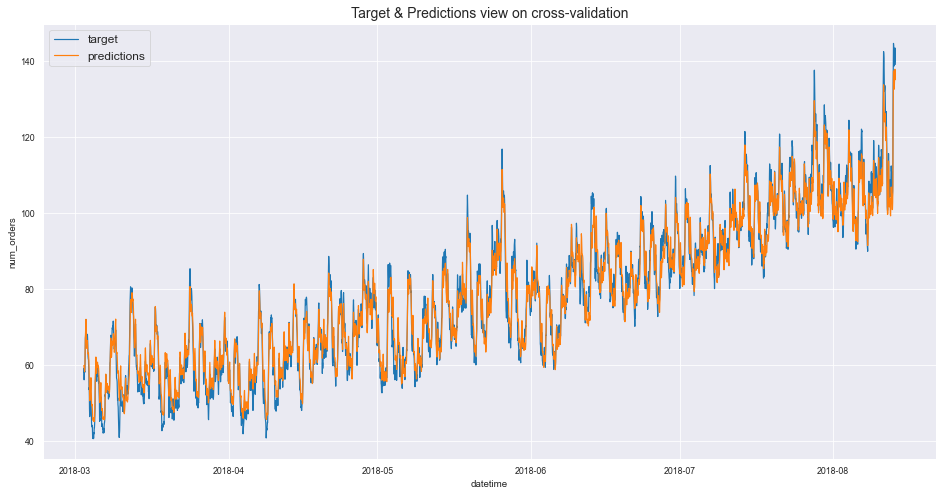

Wall time: 1min 33s


{'Model name': 'CatBoostRegressor',
 'Train time': 1.2672,
 'Predict time': 0.003,
 'RMSE train_score': 645.2709,
 'RMSE predict_score': 15.8966,
 'Parameters': {'iterations': 600,
  'learning_rate': 0.05,
  'random_state': 2718}}

In [29]:
%%time

cbr, cbr_params, cbr_result = cross_validation(
    model = CatBoostRegressor,
    X = X_train,
    y = y_train,
    param_grid = cbr_params,
    rolling_plot = rolling_plot
)
results += cbr_result
results[-1]

### LGBMRegressor

In [30]:
lgb_params = {
    "num_iterations" : range(400, 1000 + 1, 200),
    "learning_rate" : [0.05, 0.1, 0.15],
    "random_state" : [2718]
}

Fitting 6 folds for each of 12 candidates, totalling 72 fits


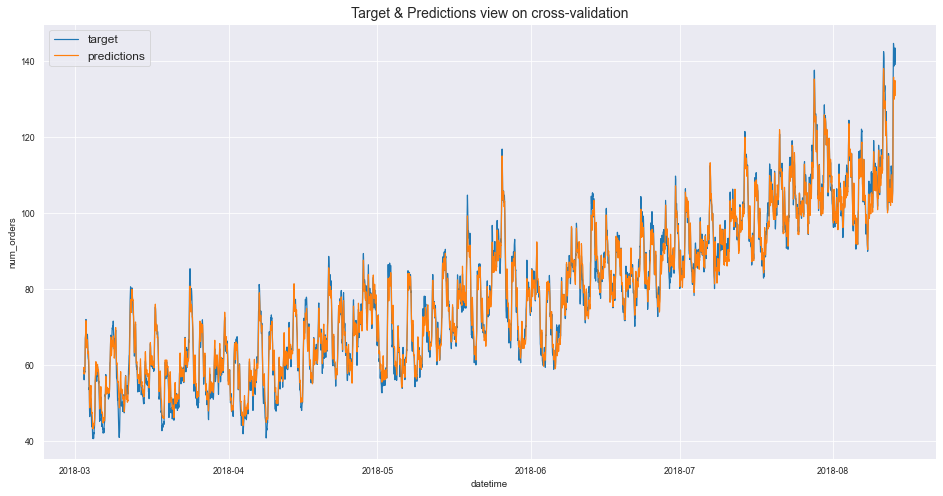

Wall time: 18.7 s


{'Model name': 'LGBMRegressor',
 'Train time': 0.2513,
 'Predict time': 0.0259,
 'RMSE train_score': 653.3723,
 'RMSE predict_score': 11.1142,
 'Parameters': {'learning_rate': 0.05,
  'num_iterations': 400,
  'random_state': 2718}}

In [31]:
%%time

lgb, lgb_params, lgb_result = cross_validation(
    model=LGBMRegressor,
    X = X_train,
    y = y_train,
    param_grid = lgb_params,
    rolling_plot = rolling_plot
)

results += lgb_result
results[-1]

Посмотрим на результаты обучения

In [32]:
def view_results(results : list):    
    return (pd.DataFrame(results)
        .style
        .highlight_min(color='orange')
        .highlight_max(color='lightgreen')
    )

In [33]:
view_results(results)

,Model name,Train time,Predict time,RMSE train_score,RMSE predict_score,Parameters
0,LinearRegression,0.003000,0.002000,1078.971800,31.172700,{}
1,DecisionTreeRegressor,0.012000,0.003000,1024.013100,27.012700,"{'max_depth': 4, 'min_samples_leaf': 1, 'min_samples_split': 2, 'random_state': 2718}"
2,RandomForestRegressor,0.526600,0.015000,934.690700,25.611200,"{'max_depth': 4, 'min_samples_leaf': 2, 'min_samples_split': 2, 'random_state': 2718}"
3,CatBoostRegressor,1.267200,0.003000,645.270900,15.896600,"{'iterations': 600, 'learning_rate': 0.05, 'random_state': 2718}"
4,LGBMRegressor,0.251300,0.025900,653.372300,11.114200,"{'learning_rate': 0.05, 'num_iterations': 400, 'random_state': 2718}"


**Выводы:**
1. Наилучшие результаты по `метрике` имеет `CatBoostRegressor`;
2. Наилучший результат по времени обучения `LinearRegression`.

# 4. Тестирование

In [32]:
def get_test(model, X_test, y_test, rolling_plot):
    # Predict
    start = time()
    predictions = model.predict(X_test)
    predict_time = time() - start
    # RMSE
    rmse_metrics = rmse(y_test, predictions)
    
    # Call plot_predictions
    plot_predictions(X_test, y_test, predictions, rolling_plot)
    return [{
            "Model name" : type(model).__name__,
            "Predict test time" : round(predict_time, 4),
            "RMSE test score" : round(rmse_metrics, 4),
            "Parameters" : model.get_params(model),
        }]

In [33]:
test_results = []
rolling_plot = 7

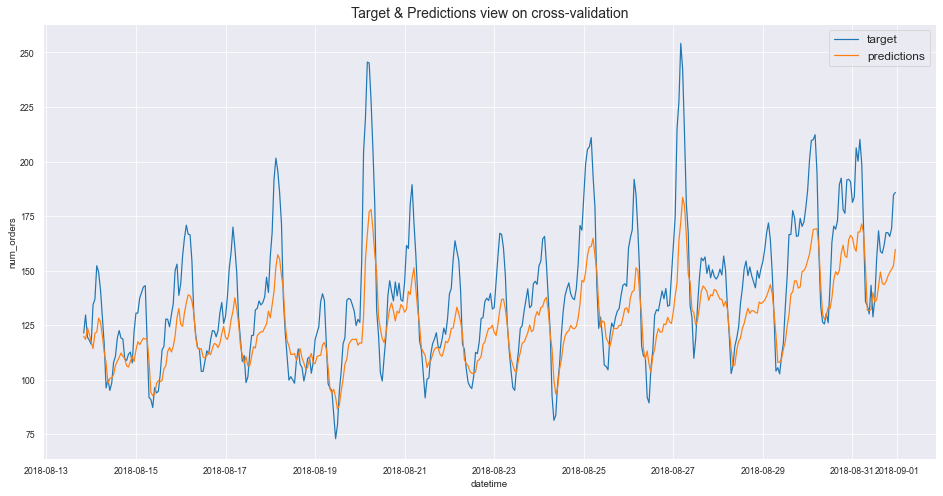

In [34]:
# LinearRegressor
test_results += get_test(lr, X_test, y_test, rolling_plot)

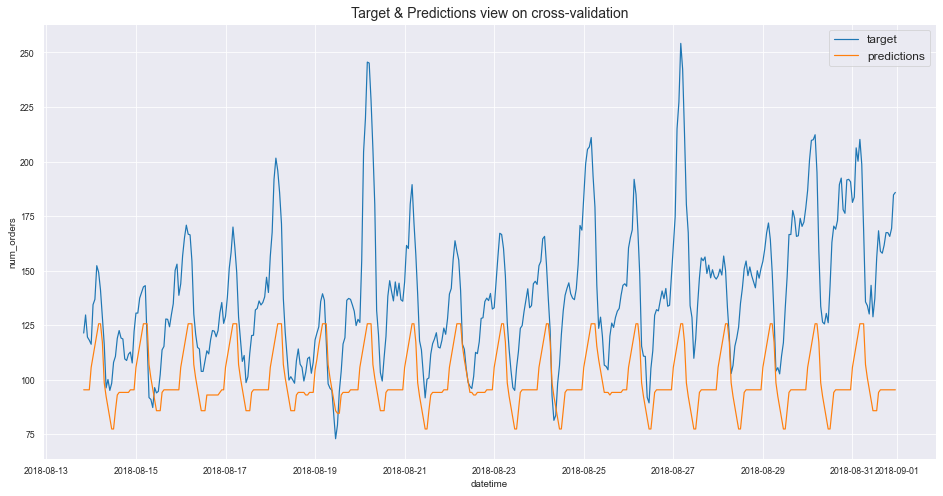

In [35]:
# DecisionTreeRegressor
test_results += get_test(tree, X_test, y_test, rolling_plot)

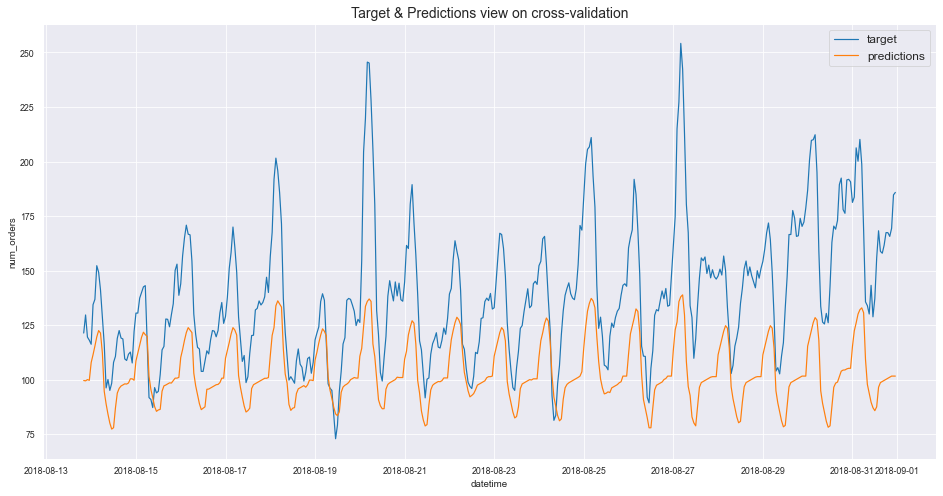

In [36]:
# RandomForestRegressor
test_results += get_test(rf, X_test, y_test, rolling_plot)

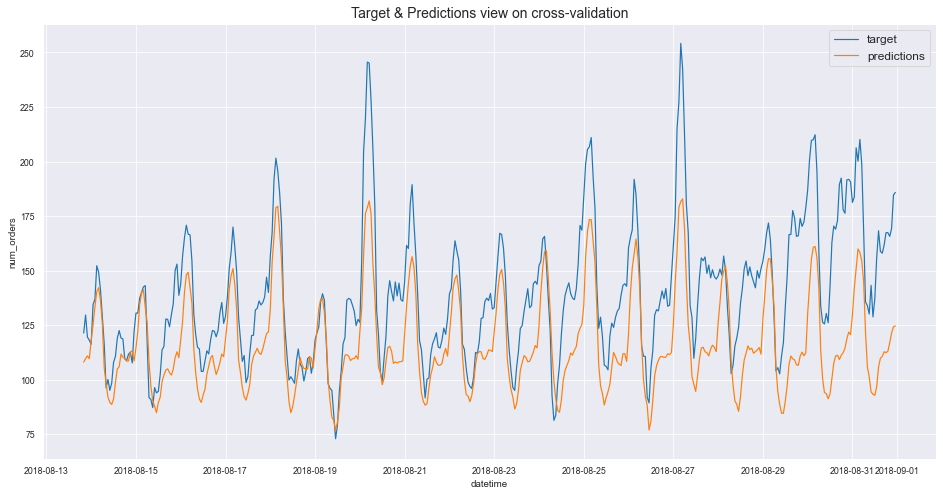

In [37]:
# CatBoostRegressor
test_results += get_test(cbr, X_test, y_test, rolling_plot) 

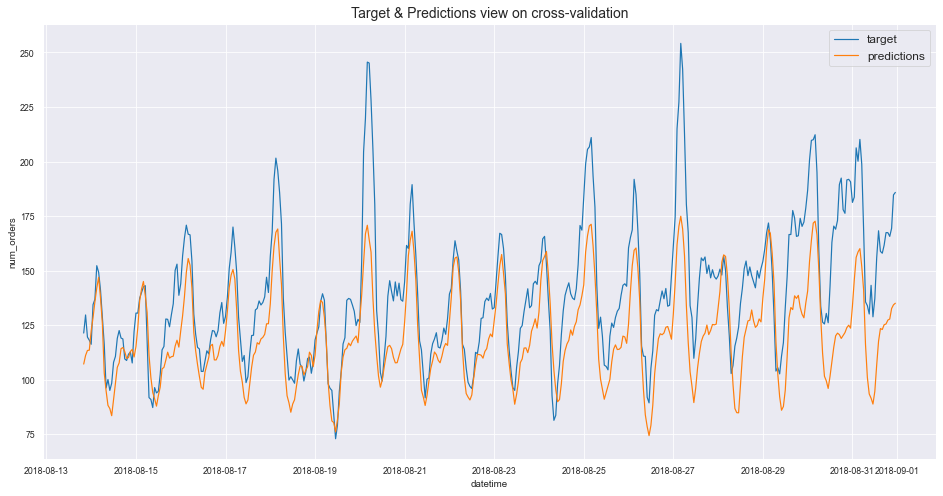

In [38]:
# LGBMRegression
test_results += get_test(lgb, X_test, y_test, rolling_plot)

**Выделим удачные модели.**

In [39]:
def color_completed(value):
    color = 'orange' if value==True else 'black'
    return 'color: %s'%color

In [40]:
for result in test_results:
    rmse_threshold = 48.0
    if result["RMSE test score"] <= rmse_threshold:
        result["Completed?"] = True
    else:
        result["Completed?"] = False

In [41]:
view_results(test_results).applymap(color_completed)

,Model name,Predict test time,RMSE test score,Parameters,Completed?
0,LinearRegression,0.002,52.738,"{'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'normalize': False}",False
1,DecisionTreeRegressor,0.001,62.7374,"{'criterion': 'mse', 'max_depth': 4, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'presort': False, 'random_state': 2718, 'splitter': 'best'}",False
2,RandomForestRegressor,0.002,59.6656,"{'bootstrap': True, 'criterion': 'mse', 'max_depth': 4, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 3, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 10, 'n_jobs': None, 'oob_score': False, 'random_state': 2718, 'verbose': 0, 'warm_start': False}",False
3,CatBoostRegressor,0.002,46.3996,"{'loss_function': 'RMSE', 'iterations': 600, 'learning_rate': 0.05, 'random_state': 2718}",True
4,LGBMRegressor,0.008,44.0304,"{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.05, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 100, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': 2718, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0, 'num_iterations': 400}",True


# 5. Выводы

Были использованы следующие признаки, составленные из данных, исходя из анализа:
1. Скользящее среднее с окном в 3 недели;
2. Месяц, неделя, день недели, час.

В результате получили наилучшие резулаты у градиентного бустнига `CatBoostRegressor`. 
Также стоит отметить, что порог (`RMSE_threshold = 48.0`) ещё преодолел градиентный бустинг `LGBMRegressor`.